In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import random

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate Percent Replicating of the DMSO wells by considering DMSO in the same position to be replicates. This is done to estimate position effects. The following are the steps taken

- Normalized, feature selected profiles are read and the replicate plates are merged into a single dataframe.
- All treatment, Positive control and empty wells are removed from the dataframe.
- The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
- The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
- Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution.
- The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.

In [2]:
experiment_df = pd.read_csv('output/experiment-metadata.tsv', sep='\t')

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_Well'
n_replicates = experiment_df.shape[0]
n_samples = 1000

In [3]:
all_plates_df = pd.DataFrame()

for i, plate in enumerate(experiment_df.Assay_Plate_Barcode.unique()):
    batch = experiment_df.loc[i, 'Batch']
    df = (
        pd.read_csv(f'../profiles/{batch}/{plate}/{plate}_normalized_feature_select_batch.csv.gz')
    )
    all_plates_df = utils.concat_profiles(all_plates_df, df)

all_plates_df = all_plates_df[all_plates_df.Metadata_control_type=="negcon"]

In [4]:
replicating_corr_df = utils.corr_between_replicates_df(all_plates_df, group_by_feature)
replicating_corr = replicating_corr_df.replicate_correlation
null_replicating = utils.corr_between_non_replicates(all_plates_df, n_samples, n_replicates, group_by_feature)

prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicating_corr, how='right')

corr_replicating_df = corr_replicating_df.append({'Description':f'DMSO wells',
                                                  'Replicating':replicating_corr,
                                                  'Null_Replicating':null_replicating,
                                                  'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                  'Value_95':value_95_replicating}, ignore_index=True)

In [5]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| DMSO wells    |                  54.4 |


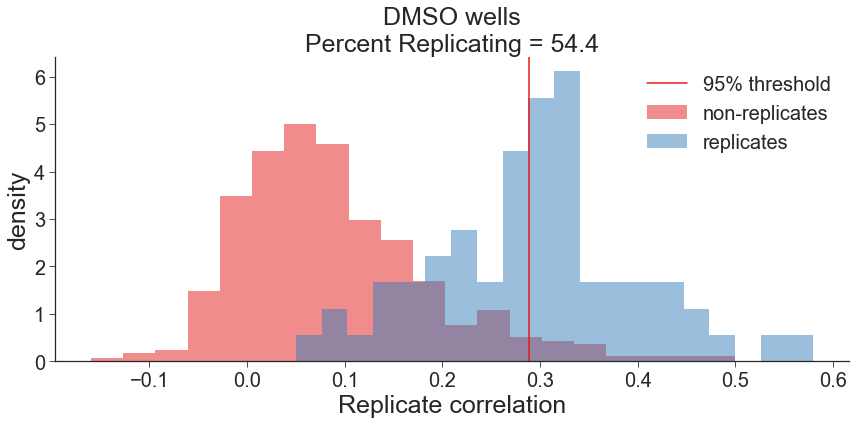

In [6]:
utils.distribution_plot(df=corr_replicating_df, output_file="3.control_percent_replicating_position.png", metric="Percent Replicating")